In [ ]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import math
import colorsys

In [ ]:
filePath    = "Airports2.csv"
yearList    = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
states      = ["CA", "NY"]

data = pd.read_csv(filePath)
data = data.dropna()

# creates the sample size
sample = data.sample(int(percentage*len(data)))

# gets the source and dest states of each flight
sample['Source_state'] = sample['Origin_city'].apply( lambda x: x.split(', ')[1])
sample['Dest_state']   = sample['Destination_city'].apply(lambda x: x.split(', ')[1])

# gets the years and months of flights
sample['Year']  = sample['Fly_date'].apply(lambda x: x.split('-')[0])
sample          = sample[sample['Year'].isin(yearList)]
sample['Month'] = sample['Fly_date'].apply(lambda x: int(x.split('-')[1]))

# If stateSet not given creates it based on the states in the sample
if states == None:
    sourceStateSet  = set(sample['Source_state'].drop_duplicates())
    destStateSet    = set(sample['Dest_state'].drop_duplicates())
    state        = sourceStateSet.union(destStateSet)

#limits flights looked at based upon stateSet
cond    = (sample['Source_state'].isin(states) & sample['Dest_state'].isin(states))
sample  = sample[cond]

# Creates dictionary (airport_state) where keys are the airports
# and the values are the state associated with it
source_pairs         = sample[['Origin_airport', 'Source_state']].drop_duplicates()
dest_pairs           = sample[['Destination_airport','Dest_state']].drop_duplicates()
source_pairs.columns = ['Airport', 'State']
dest_pairs.columns   = ['Airport', 'State']
unique_pairs         = pd.concat([source_pairs, dest_pairs], axis=0).drop_duplicates()
airport_state        = unique_pairs.set_index('Airport')['State']

# gets unique airports in sample
source_apts         = sample['Origin_airport'].drop_duplicates()
dest_apts           = sample['Destination_airport'].drop_duplicates()
source_apts.columns = ['Airport']
dest_apts.columns   = ['Airport']
unique_airports     = pd.concat([source_apts, dest_apts], axis=0).drop_duplicates()

# Creates a dict (arpt_count) that associates every airport with it's y-coordinate
arpt_count = {}
i = 0
for airport in unique_airports:
    arpt_count[airport] = i
    i += 1




In [ ]:
def removeOutliersKamada(Graph, Position, sample):
    # Calculate standard deviation of y
    y_coords = [pos[1] for pos in Position.values()]
    y_coords = list(y_coords) #Convert it to a list because otherwise Python doesn't like it.
    y_mean = sum(y_coords) / len(y_coords)
    y_std_dev = math.sqrt(sum((y - y_mean) ** 2 for y in y_coords) / len(y_coords))

    # Threshold for outliers
    y_threshold = 3 * y_std_dev

    # Keys to Remove
    keys_to_remove = []
    for key, pos in Position.items():
        y = pos[1]
        if abs(y - y_mean) > y_threshold:
            print(key)
            keys_to_remove.append(key)
    if len(keys_to_remove) == 0:
      return Position, sample
    # Remove nodes
    for key in keys_to_remove:
        sample = sample[(sample['Origin_airport'] != key) & (sample['Destination_airport'] != key)]
        del airport_state[key]
        Graph.remove_node(key)
    return removeOutliersKamada(Graph, nx.kamada_kawai_layout(Graph), sample)

# removeOutliersSpring(G, nx.spring_layout(G))

In [ ]:
#def makeBaseGraph(sample, airport_state, arpt_count, stateSet):
G = nx.DiGraph()

# creates graph with positions of source on x-val = 0 dest x-val = 1
# y-val are determined by airport

pos = {}
def add_edge(row):
    if (row['Origin_airport'], row['Destination_airport']) in G.edges():
      G[row['Origin_airport']][row['Destination_airport']]['weight'] += 1
    else:
      G.add_edge(row['Origin_airport'], row['Destination_airport'])
      G[row['Origin_airport']][row['Destination_airport']]['weight'] = 1

    pos[row['Origin_airport']]      = [0, arpt_count[row['Origin_airport']] * 8]
    pos[row['Destination_airport']] = [400, arpt_count[row['Destination_airport']] * 8]

_ = sample.apply(add_edge, axis=1)

In [ ]:
posKBase, sample = removeOutliersKamada(G, nx.kamada_kawai_layout(G, weight = 'weight'), sample)
# generates a random unique color for every state in stateSet
def get_colors(n): return set("#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n))
colors = list(get_colors(len(states)))

# Maps a unique color to each state
i = 0
colorMap = {}
for state in states:
    colorMap[state] = colors[i]
    i += 1

# Creates a list of colors based upon the order of the nodes in the graph
# and the state they correlate to
node_colors = []
for n in G.nodes():
    if n not in airport_state:
        continue
    node_colors.append(colorMap[airport_state[n]])

edge_colors = []
for edge in G.edges():
  source = airport_state[edge[0]]
  dest   = airport_state[edge[1]]
  if source==dest:
    edge_colors.append(colorMap[source])
  else:
    edge_colors.append("#000000")

posKBase = nx.kamada_kawai_layout(G, weight = 'weight')

LGD
OGS
SNS
UVA
LNS


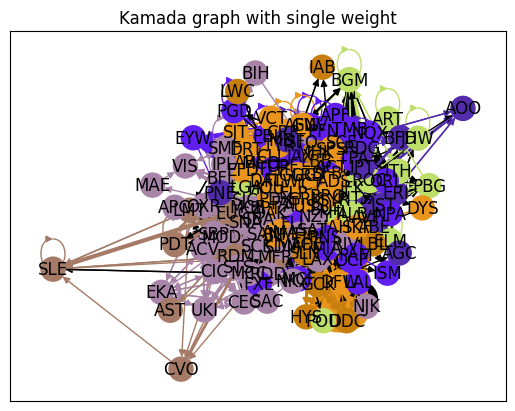

In [ ]:
weightsUsed = [G.edges()[edge]['weight']//100 + 1 for edge in G.edges()]
nx.draw_networkx_edges(G, pos=posKBase, width=weightsUsed, edge_color = edge_colors);
nx.draw_networkx_nodes(G, pos=posKBase, node_color = node_colors)
nx.draw_networkx_labels(G, pos = posKBase);
plt.title("Kamada graph with single weight");

In [ ]:
KamadaPos = nx.kamada_kawai_layout(G, weight = 'weight')
KamadaPos = pd.Series(KamadaPos)
xVals, yVals = zip(*KamadaPos)
coordsK = pd.DataFrame({
    'xVals' : xVals,
    'yVals' : yVals
})

coordsK.index = list(G.nodes())

from sklearn.decomposition import PCA
import numpy as np

#combines the x and y coordinates into 1 values
pca = PCA(n_components=1)
y_pca = pca.fit_transform(coordsK)
coordsK = pd.Series(y_pca.flatten())
coordsK.index = list(G.nodes())

In [ ]:
# Given data, the airport_state dict, and the stateSet creates a graph depicting
# the flights between the states in stateSet during a specific year.
# New nodes are essentailly made for each month in the year, and
# positioning is based on the month (x-val) and the airport (y-val)

# makes a graph as well as the coordinates (pos) of each node
GYear = nx.DiGraph()
posYear = {}
def add_edge(row):
  year = int(row['Year'])
  sourceArpt = row['Origin_airport']
  destArpt   = row['Destination_airport']

  #creates node names
  sourceNode = '%s_%s' % (sourceArpt, year)
  destNode   = '%s_%s' % (destArpt, year + 1)
  if (sourceNode, destNode) in GYear.edges():
    GYear[sourceNode][destNode]['weight'] += 1
  else:
    GYear.add_edge(sourceNode, destNode)
    GYear[sourceNode][destNode]['weight'] = 1

  # Each nodes x coordinate is determined by the month of the flight
  # However, the y coordinate is consistent but random/not purposeful
  posYear[sourceNode] = [year, coordsK[sourceArpt]]
  posYear[destNode] = [year + 1, coordsK[destArpt]]

_ = sample.apply(add_edge, axis=1)

In [ ]:
#generates a random unique color for every state in stateSet
colors = []
cmap = plt.get_cmap('tab20')
for i in range(len(states) // 2):
    colors.append(cmap(i / (len(states) // 2)))

# Generate second half of colors using HSL
for i in range(len(states) // 2, len(states)):
    hue = i / len(states)
    lightness = 0.5
    saturation = 0.8
    rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
    colors.append(rgb)

# Maps a unique color to each state
i = 0
colorMap = {}
for state in states:
  colorMap[state] = colors[i]
  i += 1

# Creates a list of colors based upon the order of the nodes in the graph
# and the state they correlate to

# removeOutliersKamada(GYear, posYear)

node_colorsYear = []
for n in GYear.nodes():
  if (n[:3]) not in airport_state:
    continue
  node_colorsYear.append(colorMap[airport_state[n[:3]]])

edge_colorsYear = []
for edge in GYear.edges():
  source = airport_state[edge[0][:3]]
  dest   = airport_state[edge[1][:3]]
  if source==dest:
    edge_colorsYear.append(colorMap[source])
  else:
    edge_colorsYear.append("#000000")

In [ ]:
weights = [GYear.edges()[edge]['weight'] for edge in GYear.edges()]
sourceStates = []
destStates   = []
year = []

for s, d in list(GYear.edges()):
  sourceStates.append(airport_state[s[:3]])
  destStates.append(airport_state[d[:3]])
  year.append(int(s[4:]))

GYearDF = pd.DataFrame({
    'Source State' : sourceStates,
    'Dest State' : destStates,
    'Year' : year,
    'Weight' : weights
})

cond = ((GYearDF['Year']>=1998) & (GYearDF['Year']<=2002)) & (((GYearDF['Source State'] == 'NY') & (GYearDF['Dest State'] == 'CA')) \
      | ((GYearDF["Source State"] == 'CA') & (GYearDF["Dest State"] == 'NY')))
GYearDFCond = GYearDF[cond]
print(GYearDFCond['Weight'].sum())

cond = ((GYearDF['Year']<1998) | (GYearDF['Year']>2002)) & (((GYearDF['Source State'] == 'NY') & (GYearDF['Dest State'] == 'CA')) \
      | ((GYearDF["Source State"] == 'CA') & (GYearDF["Dest State"] == 'NY')))
GYearDF = GYearDF[cond]
print(GYearDF['Weight'].sum())


4320
12122


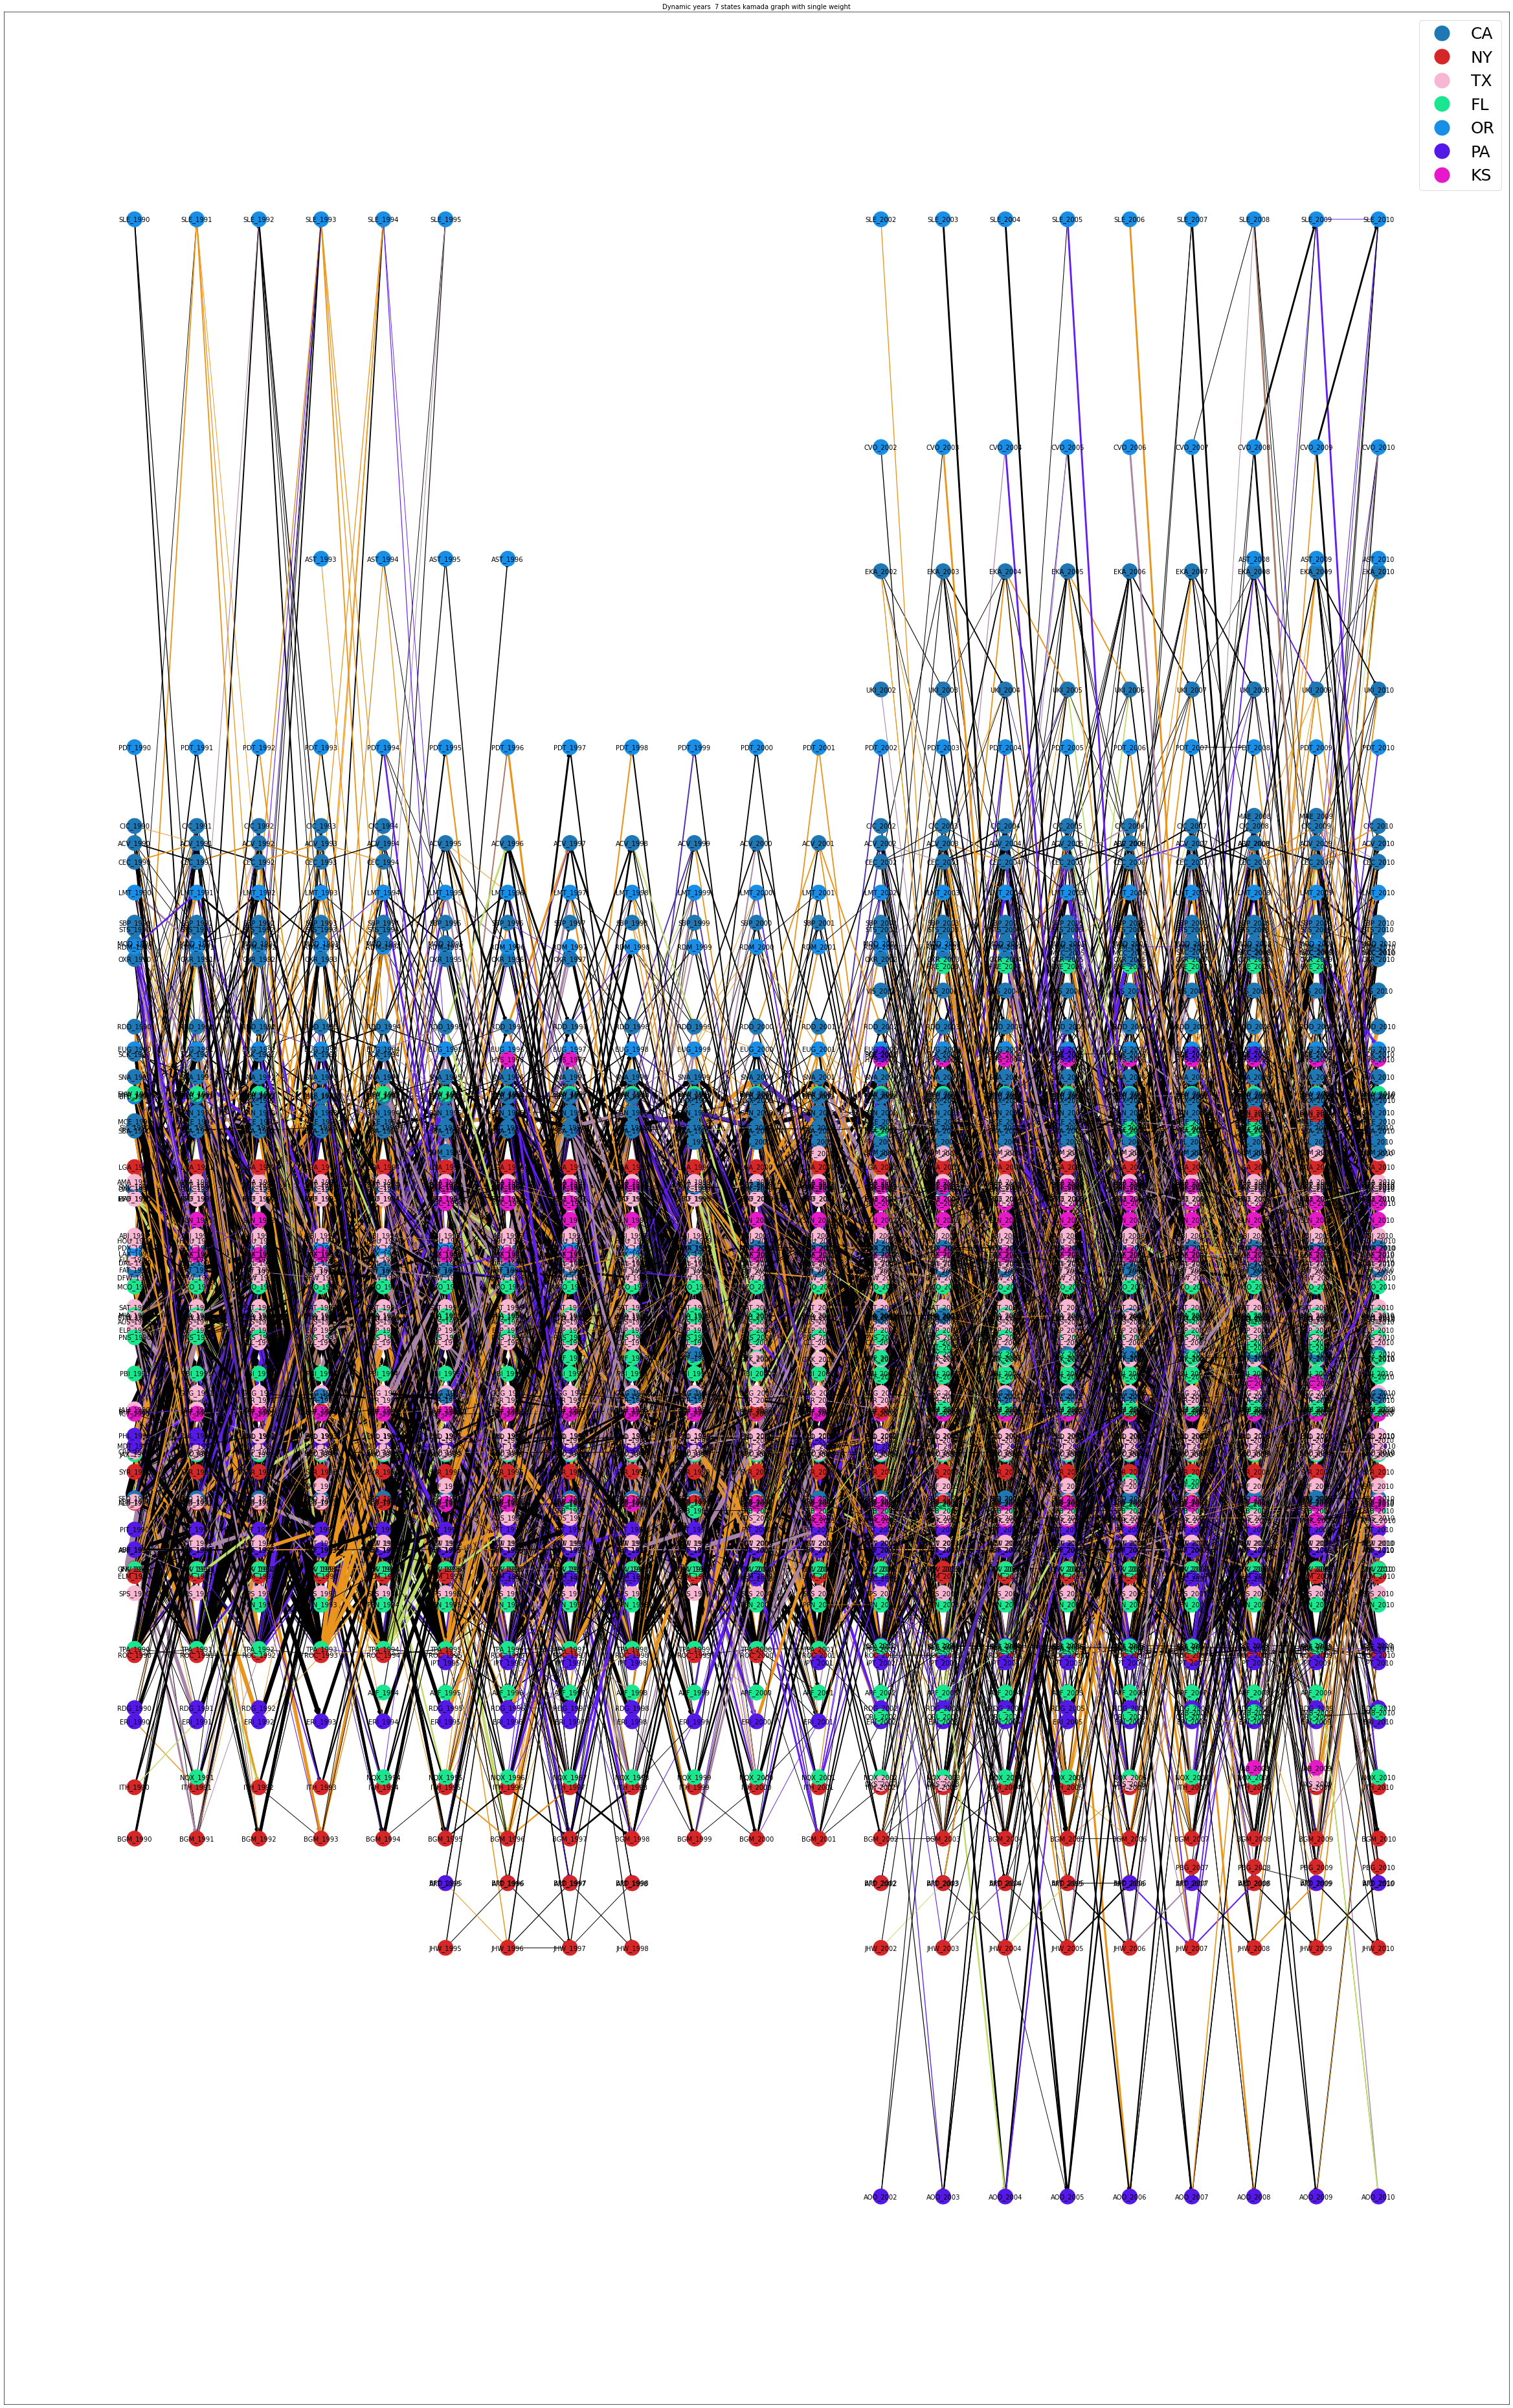

In [ ]:
fig = plt.figure(1, figsize=(50, 80), dpi=60)
state_labels = {state: f'{state} ({color})' for state, color in colorMap.items()}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label)
                  for label, color in colorMap.items()]
plt.legend(handles=legend_handles, loc='upper right', prop = {'size': 30}, markerscale = 5)

weightsUsed = [GYear.edges()[edge]['weight']/10 + 1 for edge in GYear.edges()]
nx.draw_networkx_edges(GYear, pos=posYear, width=weightsUsed, edge_color = edge_colors);
nx.draw_networkx_nodes(GYear, pos=posYear, node_color = node_colorsYear, node_size = 800)
nx.draw_networkx_labels(GYear, pos = posYear);
plt.title("Dynamic years  7 states kamada graph with single weight");